In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
url = 'http://snap.stanford.edu/data/amazon/Books.txt.gz'
r = requests.get(url, allow_redirects=True)
open('/content/drive/MyDrive/NLP/Books.txt.gz', 'wb').write(r.content)

4691062433

In [ ]:
%cd /content/drive/MyDrive/NLP

/content/drive/MyDrive/NLP


In [ ]:
!ls

book.csv  Books.txt.gz	weightedData


# Import Libraries

In [ ]:
import gzip
import re
from tqdm import tqdm
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter  # to get the most common words in a string 
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample

vocab = Counter()
sns.reset_defaults()

# Load the data

In [ ]:
def parse(filename):
  f = gzip.open(filename, 'r')
  entry = {}
  for l in f:
    l = l.decode("ascii")
    l = l.strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

In [ ]:
dict = []
reviews_num = 0
for e in tqdm(parse("Books.txt.gz")):
  dict.append(e)
  reviews_num += 1
  if reviews_num==300000:
    break

299999it [00:19, 15071.24it/s]


In [ ]:
df=pd.DataFrame(dict)

In [ ]:
df.head()

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,unknown,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,unknown,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,unknown,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,unknown,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,unknown,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


# Data Preparation

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   product/productId   300000 non-null  object
 1   product/title       300000 non-null  object
 2   product/price       300000 non-null  object
 3   review/userId       300000 non-null  object
 4   review/profileName  300000 non-null  object
 5   review/helpfulness  300000 non-null  object
 6   review/score        300000 non-null  object
 7   review/time         300000 non-null  object
 8   review/summary      300000 non-null  object
 9   review/text         300000 non-null  object
dtypes: object(10)
memory usage: 22.9+ MB


In [ ]:
df['product/title'].value_counts()

The Hobbitt, or there and back again; illustrated by the author.    4420
The Giver                                                           3822
Great Expectations                                                  3295
Fahrenheit 451                                                      3287
ERAGON: INHERITANCE, BOOK ONE.                                      3137
                                                                    ... 
Consider the lilies                                                    1
Projects Grudge and Bluebook Reports 1-12                              1
Principles of Polymer Processing                                       1
Two people,: A novel                                                   1
Its Only Art If Its Well Hung!                                         1
Name: product/title, Length: 21170, dtype: int64

## Remove extra columns

In [ ]:
df = df.drop(['product/productId', 'product/price', 'review/profileName', 'review/time','review/summary','review/helpfulness'], axis=1)

In [ ]:
df.head()

,product/title,review/userId,review/score,review/text
0,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,4.0,This is only for Julie Strain fans. It's a col...
1,Dr. Seuss: American Icon,A30TK6U7DNS82R,5.0,I don't care much for Dr. Seuss but after read...
2,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,5.0,"If people become the books they read and if ""t..."
3,Dr. Seuss: American Icon,A2MVUWT453QH61,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,Dr. Seuss: American Icon,A22X4XUPKF66MR,4.0,Philip Nel - Dr. Seuss: American IconThis is b...


## Renaming columns

In [ ]:
df.columns = ['title', 'userID', 'rating', 'review']

In [ ]:
df.head()

,title,userID,rating,review
0,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,4.0,This is only for Julie Strain fans. It's a col...
1,Dr. Seuss: American Icon,A30TK6U7DNS82R,5.0,I don't care much for Dr. Seuss but after read...
2,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,5.0,"If people become the books they read and if ""t..."
3,Dr. Seuss: American Icon,A2MVUWT453QH61,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,Dr. Seuss: American Icon,A22X4XUPKF66MR,4.0,Philip Nel - Dr. Seuss: American IconThis is b...


## Removing unknown users

In [ ]:
df['userID'].value_counts()

unknown           57928
A14OJS0VWMOSWO      595
AFVQZQ8PW0L         348
A1D2C0WDCSHUWZ      302
A1X8VZWTOG8IS6      196
                  ...  
AVPNXVZ21A64I         1
AMCIA92NNAPS0         1
A1HJ8OG8HHT6FN        1
A1N6UIVLKUF9WF        1
A3C0QW38ODO7CX        1
Name: userID, Length: 170482, dtype: int64

In [ ]:
df.shape

(300000, 4)

In [ ]:
df = df.loc[df['userID'] != "unknown"]

In [ ]:
df.shape

(242072, 4)

## Remove duplicates

In [ ]:
sum(df.duplicated())

9730

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
sum(df.duplicated())

0

In [ ]:
df.shape

(232342, 4)

## Mapping ratings to Positive, Negative, Neutral

In [ ]:
class_mapper = {'1.0':'Negative','2.0':'Negative', '3.0':'Neutral', '4.0':'Positive', '5.0':'Positive'}

In [ ]:
df['class'] = df['rating'].replace(class_mapper)

In [ ]:
df.head()

,title,userID,rating,review,class
0,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,4.0,This is only for Julie Strain fans. It's a col...,Positive
1,Dr. Seuss: American Icon,A30TK6U7DNS82R,5.0,I don't care much for Dr. Seuss but after read...,Positive
2,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,5.0,"If people become the books they read and if ""t...",Positive
3,Dr. Seuss: American Icon,A2MVUWT453QH61,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Positive
4,Dr. Seuss: American Icon,A22X4XUPKF66MR,4.0,Philip Nel - Dr. Seuss: American IconThis is b...,Positive


## Choosing sample from the data that has balanced ratings

In [ ]:
df['class'].value_counts()

Positive    184426
Negative     27083
Neutral      20833
Name: class, dtype: int64

In [ ]:
undersample = RandomUnderSampler(random_state=42)
X_under, Y_under = undersample.fit_resample(df.iloc[:,:-1], df['class'])

In [ ]:
df = pd.concat((X_under, Y_under), axis=1)

In [ ]:
df['class'].value_counts()

Negative    20833
Neutral     20833
Positive    20833
Name: class, dtype: int64

In [ ]:
df.head()

,title,userID,rating,review,class
0,Superman: Birthright,A2KRFSS4JZNV13,1.0,"..but it's not, so the current 30 something su...",Negative
1,"Autobiography Of Benjamin Franklin, The",A1NOVRB88NSYGM,1.0,"Sometimes pastiches work well, like Bach's B M...",Negative
2,Beginning Visual Web Developer 2005 Express: F...,A2B4H6ZH0YTP3A,1.0,"THIS IS BAD NEWS!!!! LOTS OF INFO LEFT OUT, PI...",Negative
3,"The Mystery of the Alamo Ghost (Real Kids, Rea...",A11RF2BUOE5JTG,2.0,I am writing this review based on the words of...,Negative
4,The Arab-Israeli Dilemma,AR3ES795DAQ0I,2.0,I picked up this book looking for a solid and ...,Negative


## Choosing the most frequent 15 books


In [ ]:
list_books = df['title'].value_counts().index[0:15].tolist()

In [ ]:
df = df.loc[df['title'].isin(list_books)]

In [ ]:
df.shape

(5974, 5)

In [ ]:
df.nunique()

title       15
userID    5800
rating       5
review    5968
class        3
dtype: int64

In [ ]:
df['title'].value_counts()

ERAGON: INHERITANCE, BOOK ONE.                                                                                                     819
The Hobbitt, or there and back again; illustrated by the author.                                                                   570
The Bear and the Dragon                                                                                                            496
The Devil Wears Prada                                                                                                              486
The Shelters Of Stone - The Earth's Children Series, Book 5                                                                        444
The Giver                                                                                                                          422
The Great Gatsby                                                                                                                   404
Julie and Julia: 365 Days, 524 Recipes, 1 Tiny Apartmen

## Cleaning reviews text 

In [ ]:
def str_to_list(text):
    list1 = re.split(r"\s+", text)
    return list1

In [ ]:
def clean(text, flg_stemm=False):
    """
    INPUT:
    text: string of a text to be cleaned
    flg_stemm: bool to indicate whether stemming is to be applied
  
    OUTPUT:
    new_text: list of words after cleaning, and stemming

    """

    # Removing special characters, digits, and extra spaces
    new_text = re.sub(r"[^a-zA-Z']", ' ', text)
    new_text = re.sub(r"\s'|'\s", ' ', new_text)

    # Converting to lower case
    new_text = new_text.lower()

    # Tokenize the string
    new_text = str_to_list(new_text)

    # Stemming
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        new_text = [ps.stem(word) for word in new_text]

    return ' '.join(new_text)

In [ ]:
df['review'] = df['review'].apply(lambda x:clean(x))

In [ ]:
df.head()

,title,userID,rating,review,class
22,"ERAGON: INHERITANCE, BOOK ONE.",A3T18VLRQS59L0,1.0,one of the worst books i have ever read ever i...,Negative
25,"ERAGON: INHERITANCE, BOOK ONE.",A1PNBYBWGWWVEK,1.0,ahhh after reading the dying earth by jack van...,Negative
34,The Bear and the Dragon,A3CU0U5RY99NXJ,1.0,this book took so long to write that clancy fo...,Negative
35,The Devil Wears Prada,A2FAAYH5AVTGG0,1.0,while the most prominent character is the alwa...,Negative
53,"ERAGON: INHERITANCE, BOOK ONE.",A123DKR2C0ENHY,2.0,i bought the sample and just couldnt get into ...,Negative


# Recommendation system 

## 1. Popularity Based (Top In whole collection)

We have sorted the dataset according to the total ratings each of the books have received in non-increasing order and then recommended top n books.

so here it sound that the sysytem recommend a book with the highest rate . 
- it may be an initial step to start a conversation between the chatbot and between the reader. 


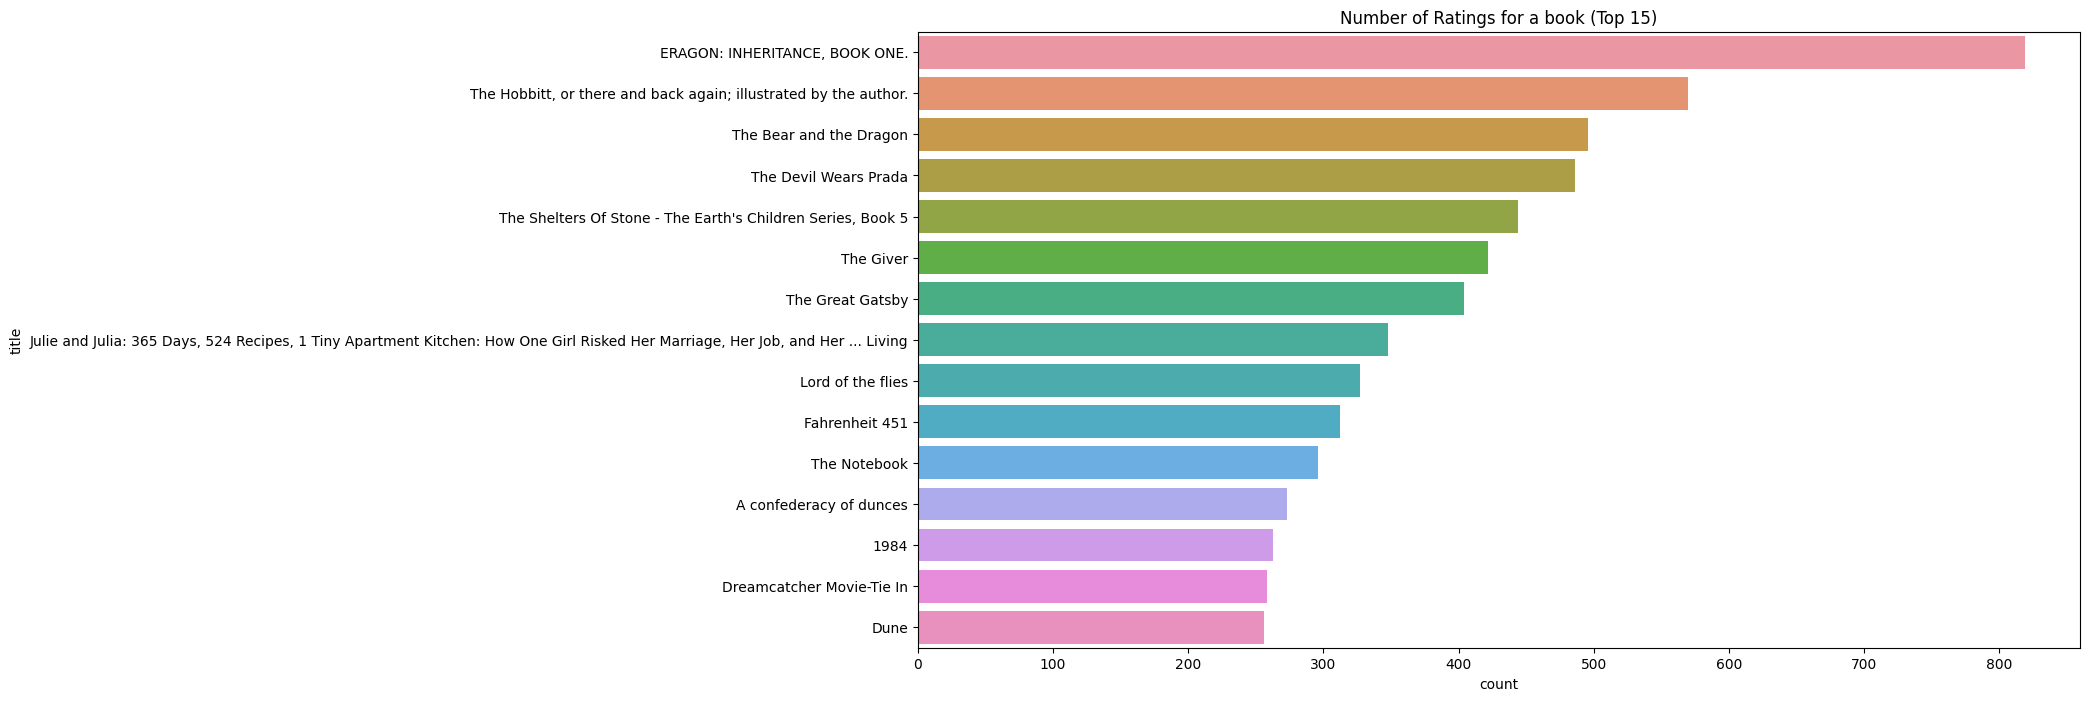

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y="title", data=df, order=df['title'].value_counts().index[0:15])
plt.title("Number of Ratings for a book (Top 15)")
plt.show()

In [ ]:
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('title')['rating'].count()).sort_values('rating', ascending=False).head(n)
        return data
    return "Invalid number of books entered!!"

In [ ]:
popularity_based(df, 10)

,rating
title,
"ERAGON: INHERITANCE, BOOK ONE.",819
"The Hobbitt, or there and back again; illustrated by the author.",570
The Bear and the Dragon,496
The Devil Wears Prada,486
"The Shelters Of Stone - The Earth's Children Series, Book 5",444
The Giver,422
The Great Gatsby,404
"Julie and Julia: 365 Days, 524 Recipes, 1 Tiny Apartment Kitchen: How One Girl Risked Her Marriage, Her Job, and Her ... Living",348
Lord of the flies,327


## 2.2 Recommendation using Average Weighted Rating

We have calculated the weighted score using the below formula for all the books and recommended the books with the highest score.

- score= t/(t+m)∗a + m/(m+t)∗c

where : 
- t represents the total number of ratings received by the book
- m represents the minimum number of total ratings considered to be included
- a represents the average rating of the book and,
- c represents the mean rating of all the books.

In [ ]:
def str2Flot(sLst):
  flostLst = []
  for i in sLst:
    flostLst.append(float(i))
  return flostLst

def avgRating(newdf2, df,lst):
    newdf = newdf2
    newdf['Average_Rating'] = 0
    for x in range(len(lst)):
        strLst = list(df.loc[df['title'] == lst[x]]['rating'])
        l = str2Flot(strLst)
        newdf['Average_Rating'][x] = sum(l)/len(l)
    return newdf

In [ ]:
df2 = pd.DataFrame(df['title'].value_counts())
df2['Total_Ratings'] = df2['title']
df2['Book_Title'] = df2.index
df2.reset_index(level=0, inplace=True)
df2 = df2.drop('index',axis=1)

lst=list(df2['Book_Title'])

df2 = avgRating(df2, df,lst)
df2.to_pickle('weightedData')
df2 = pd.read_pickle('weightedData')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
df2

,title,Total_Ratings,Book_Title,Average_Rating
0,819,819,"ERAGON: INHERITANCE, BOOK ONE.",2
1,570,570,"The Hobbitt, or there and back again; illustra...",3
2,496,496,The Bear and the Dragon,2
3,486,486,The Devil Wears Prada,2
4,444,444,The Shelters Of Stone - The Earth's Children S...,2
5,422,422,The Giver,3
6,404,404,The Great Gatsby,3
7,348,348,"Julie and Julia: 365 Days, 524 Recipes, 1 Tiny...",1
8,327,327,Lord of the flies,2
9,312,312,Fahrenheit 451,3


In [ ]:
## C - Mean vote across the whole
C = df2['Average_Rating'].mean()

## Minimum number of votes required to be in the chart
m = df2['Total_Ratings'].quantile(0.90)

In [ ]:
def weighted_rating(x, m=m, C=C): 
    v = x['Total_Ratings']    #v - number of votes
    R = x['Average_Rating']   #R - Average Rating   
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
df2 = df2.loc[df2['Total_Ratings'] >= m]  # determine the thrshold for the minimum number of votes 

df2['score'] = df2.apply(weighted_rating, axis=1)
df2 = df2.sort_values('score', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print("Recommended Books using  Average Weighted Rating method:")
df2

Recommended Books using  Average Weighted Rating method:


,title,Total_Ratings,Book_Title,Average_Rating,score
1,570,570,"The Hobbitt, or there and back again; illustra...",3,2.675552
0,819,819,"ERAGON: INHERITANCE, BOOK ONE.",2,2.132509


## 2.3 User-Item Collaborative Filtering Recommendation

Collaborative Filtering Recommendation System works by considering user ratings and finds cosine similarities in ratings by several users to recommend books.

In [ ]:
# Selecting books with total ratings equals to or more than 50 (Because of availability of limited resources)
df3 = pd.DataFrame(df['title'].value_counts())
df3['Total_Ratings'] = df3['title']
df3['Book_Title'] = df3.index
df3.reset_index(level=0, inplace=True)
df3 = df3.drop('index',axis=1)


In [ ]:
df3

,title,Total_Ratings,Book_Title
0,819,819,"ERAGON: INHERITANCE, BOOK ONE."
1,570,570,"The Hobbitt, or there and back again; illustra..."
2,496,496,The Bear and the Dragon
3,486,486,The Devil Wears Prada
4,444,444,The Shelters Of Stone - The Earth's Children S...
5,422,422,The Giver
6,404,404,The Great Gatsby
7,348,348,"Julie and Julia: 365 Days, 524 Recipes, 1 Tiny..."
8,327,327,Lord of the flies
9,312,312,Fahrenheit 451


In [ ]:
df3 = df.merge(df3, left_on = 'title', right_on = 'Book_Title', how = 'left')

In [ ]:
df3 = df3.drop(['title_x','title_y','review'],axis=1)
df3

,userID,rating,class,Total_Ratings,Book_Title
0,A3T18VLRQS59L0,1.0,Negative,819,"ERAGON: INHERITANCE, BOOK ONE."
1,A1PNBYBWGWWVEK,1.0,Negative,819,"ERAGON: INHERITANCE, BOOK ONE."
2,A3CU0U5RY99NXJ,1.0,Negative,496,The Bear and the Dragon
3,A2FAAYH5AVTGG0,1.0,Negative,486,The Devil Wears Prada
4,A123DKR2C0ENHY,2.0,Negative,819,"ERAGON: INHERITANCE, BOOK ONE."
...,...,...,...,...,...
5969,ASNWGSAJZI99V,4.0,Positive,273,A confederacy of dunces
5970,A1WCJEZS66D224,5.0,Positive,404,The Great Gatsby
5971,A1HL8QSFHAYWVI,5.0,Positive,312,Fahrenheit 451
5972,A5UWC7ZERWGY6,5.0,Positive,486,The Devil Wears Prada


In [ ]:
# define a threshold for the ratings so we will take the books that rated atleast 50 times 
popularity_threshold = 50
popular_book = df3[df3['Total_Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)

In [ ]:
popular_book

,userID,rating,class,Total_Ratings,Book_Title
0,A3T18VLRQS59L0,1.0,Negative,819,"ERAGON: INHERITANCE, BOOK ONE."
1,A1PNBYBWGWWVEK,1.0,Negative,819,"ERAGON: INHERITANCE, BOOK ONE."
2,A3CU0U5RY99NXJ,1.0,Negative,496,The Bear and the Dragon
3,A2FAAYH5AVTGG0,1.0,Negative,486,The Devil Wears Prada
4,A123DKR2C0ENHY,2.0,Negative,819,"ERAGON: INHERITANCE, BOOK ONE."
...,...,...,...,...,...
5969,ASNWGSAJZI99V,4.0,Positive,273,A confederacy of dunces
5970,A1WCJEZS66D224,5.0,Positive,404,The Great Gatsby
5971,A1HL8QSFHAYWVI,5.0,Positive,312,Fahrenheit 451
5972,A5UWC7ZERWGY6,5.0,Positive,486,The Devil Wears Prada


User - Item Collaborative Filtering

In [ ]:
testdf = pd.DataFrame()
testdf['Book_Title'] = popular_book['Book_Title']
testdf['Book_Ratings'] = popular_book['Total_Ratings']
testdf['userID'] = popular_book['userID']
testdf = testdf[['userID','Book_Ratings']].groupby(testdf['Book_Title'])


In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity

listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)

In [ ]:
number = 10 

def printBookDetails(bookID):
    print(df3[df3['Book_Title']==bookID]['Book_Title'].values[0])
 

def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    print("Input Book:")
    printBookDetails(bookID)
    
    print("\nRECOMMENDATIONS:\n")
    
    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if df3[df3['Book_Title']==indexMap[i]]['Book_Title'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(df3[df3['Book_Title']==indexMap[i]]['Book_Title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(df3[df3['Book_Title']==indexMap[i]]['Book_Title'].values[0])
    return collaborative

In [ ]:
k = list(df3['Book_Title'])[0]

collaborative = getTopRecommandations(k)

Input Book:
ERAGON: INHERITANCE, BOOK ONE.

RECOMMENDATIONS:

Dreamcatcher Movie-Tie In
The Giver
The Notebook
The Hobbitt, or there and back again; illustrated by the author.
The Shelters Of Stone - The Earth's Children Series, Book 5
The Devil Wears Prada
The Bear and the Dragon
Lord of the flies
Julie and Julia: 365 Days, 524 Recipes, 1 Tiny Apartment Kitchen: How One Girl Risked Her Marriage, Her Job, and Her ... Living
The Great Gatsby


In [ ]:
collaborative = getTopRecommandations('The Devil Wears Prada')

Input Book:
The Devil Wears Prada

RECOMMENDATIONS:

Julie and Julia: 365 Days, 524 Recipes, 1 Tiny Apartment Kitchen: How One Girl Risked Her Marriage, Her Job, and Her ... Living
ERAGON: INHERITANCE, BOOK ONE.
The Hobbitt, or there and back again; illustrated by the author.
Dune
1984
A confederacy of dunces
The Notebook
Lord of the flies
The Shelters Of Stone - The Earth's Children Series, Book 5
The Great Gatsby


## 2.4 Recommendation (specific to a user )using surprise library 

In [ ]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 3.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633728 sha256=7229d76569e468ee0193f1fdbaa4158d70a4ab804e48db9af9d377fef222da97
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from datetime import datetime
import os
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import SVD
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict

In [ ]:
ratings_dict = {'title': list(df.title),
                'userID': list(df.userID),
                'rating': list(df.rating)}

df5 = pd.DataFrame(ratings_dict)
df5.shape

reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(df5[['userID','title', 'rating']], reader)

In [ ]:
benchmark = []

for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    results = cross_validate(algorithm,data, measures=['RMSE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.258897,0.375874,0.013540
KNNBasic,1.397300,1.207367,0.072642
NMF,1.398804,0.575954,0.012022
NormalPredictor,1.837453,0.005965,0.021086


In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.2760


1.276022374675752

In [ ]:
trainset = data.build_full_trainset() 
algo = SVD()
algo.fit(trainset)
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [ ]:
def get_all_predictions(predictions):
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n

In [ ]:
all_pred = get_all_predictions(predictions)

In [ ]:
#To get top 5 reommendation
n = 5

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]

In [ ]:
tmp = pd.DataFrame.from_dict(all_pred)
tmp_transpose = tmp.transpose()

In [ ]:
tmp_transpose

,0,1,2,3,4
A3T18VLRQS59L0,"(The Hobbitt, or there and back again; illustr...","(1984, 3.637438630307424)","(Fahrenheit 451, 3.472384839790767)","(The Giver, 3.405858816064314)","(A confederacy of dunces, 3.3671367653223565)"
A1PNBYBWGWWVEK,"(The Giver, 4.045641908410767)","(The Hobbitt, or there and back again; illustr...","(1984, 3.634317033550148)","(Fahrenheit 451, 3.5297812029068143)","(The Notebook, 3.3728196407833204)"
A3CU0U5RY99NXJ,"(The Giver, 3.8378386013728685)","(The Hobbitt, or there and back again; illustr...","(Lord of the flies, 3.492167416895671)","(The Great Gatsby, 3.4845417500925127)","(A confederacy of dunces, 3.3834698395215614)"
A2FAAYH5AVTGG0,"(The Hobbitt, or there and back again; illustr...","(The Giver, 3.7659985754183163)","(1984, 3.6966966734982494)","(Fahrenheit 451, 3.611815894324713)","(Dune, 3.3653065696922226)"
A123DKR2C0ENHY,"(The Hobbitt, or there and back again; illustr...","(1984, 3.783438451929539)","(A confederacy of dunces, 3.754910247732173)","(The Giver, 3.4900183860970952)","(Fahrenheit 451, 3.2955726542203916)"
...,...,...,...,...,...
ASNWGSAJZI99V,"(The Hobbitt, or there and back again; illustr...","(1984, 4.230274249574975)","(Lord of the flies, 3.790238475603017)","(The Giver, 3.77792408408467)","(Fahrenheit 451, 3.6711725317012776)"
A1WCJEZS66D224,"(The Hobbitt, or there and back again; illustr...","(1984, 4.0297894525714)","(The Giver, 3.8384069461927757)","(Fahrenheit 451, 3.743943439155043)","(Dune, 3.706556628053958)"
A1HL8QSFHAYWVI,"(The Hobbitt, or there and back again; illustr...","(1984, 4.315914372554652)","(The Giver, 3.7915505507962273)","(Dune, 3.671573774047097)","(ERAGON: INHERITANCE, BOOK ONE., 3.53428668826..."
A5UWC7ZERWGY6,"(1984, 4.413234862304147)","(Dune, 4.083781525016289)","(The Hobbitt, or there and back again; illustr...","(The Great Gatsby, 3.842863395925901)","(Fahrenheit 451, 3.6017660126097875)"


In [ ]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return pd.DataFrame(results).T

In [ ]:
u = list(df.userID)[2]
u

'A3CU0U5RY99NXJ'

In [ ]:
#specifying the user
results = get_predictions(u)
results

,0,1,2,3,4
A3CU0U5RY99NXJ,"(The Giver, 3.8378386013728685)","(The Hobbitt, or there and back again; illustr...","(Lord of the flies, 3.492167416895671)","(The Great Gatsby, 3.4845417500925127)","(A confederacy of dunces, 3.3834698395215614)"


## 2.5 recommendation using surprize library (not spesific to a user ) 

In [ ]:
df3

,userID,rating,class,Total_Ratings,Book_Title
0,A3T18VLRQS59L0,1.0,Negative,819,"ERAGON: INHERITANCE, BOOK ONE."
1,A1PNBYBWGWWVEK,1.0,Negative,819,"ERAGON: INHERITANCE, BOOK ONE."
2,A3CU0U5RY99NXJ,1.0,Negative,496,The Bear and the Dragon
3,A2FAAYH5AVTGG0,1.0,Negative,486,The Devil Wears Prada
4,A123DKR2C0ENHY,2.0,Negative,819,"ERAGON: INHERITANCE, BOOK ONE."
...,...,...,...,...,...
5969,ASNWGSAJZI99V,4.0,Positive,273,A confederacy of dunces
5970,A1WCJEZS66D224,5.0,Positive,404,The Great Gatsby
5971,A1HL8QSFHAYWVI,5.0,Positive,312,Fahrenheit 451
5972,A5UWC7ZERWGY6,5.0,Positive,486,The Devil Wears Prada


In [ ]:


df22 = pd.DataFrame(df['title'].value_counts())
df22['Total_Ratings'] = df22['title']
df22['Book_Title'] = df22.index
df22.reset_index(level=0, inplace=True)
df22 = df22.drop('index',axis=1)

lst=list(df22['Book_Title'])

df22 = avgRating(df22, df,lst)
df22.to_pickle('weightedData')
df22 = pd.read_pickle('weightedData')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
df22

,title,Total_Ratings,Book_Title,Average_Rating
0,819,819,"ERAGON: INHERITANCE, BOOK ONE.",2
1,570,570,"The Hobbitt, or there and back again; illustra...",3
2,496,496,The Bear and the Dragon,2
3,486,486,The Devil Wears Prada,2
4,444,444,The Shelters Of Stone - The Earth's Children S...,2
5,422,422,The Giver,3
6,404,404,The Great Gatsby,3
7,348,348,"Julie and Julia: 365 Days, 524 Recipes, 1 Tiny...",1
8,327,327,Lord of the flies,2
9,312,312,Fahrenheit 451,3


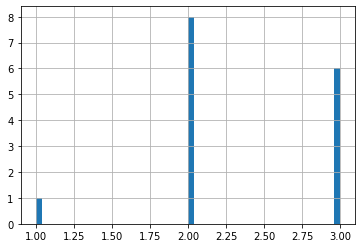

In [ ]:
# Visualize:
import matplotlib.pyplot as plt
%matplotlib inline

#visulaize the average of rates 
df22['Average_Rating'].hist(bins=50)


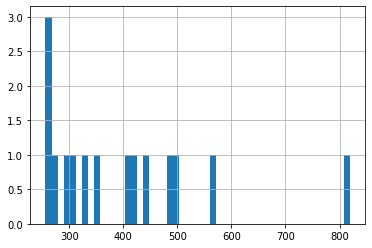

In [ ]:
# visualize number of ratings 
df22['Total_Ratings'].hist(bins=50)

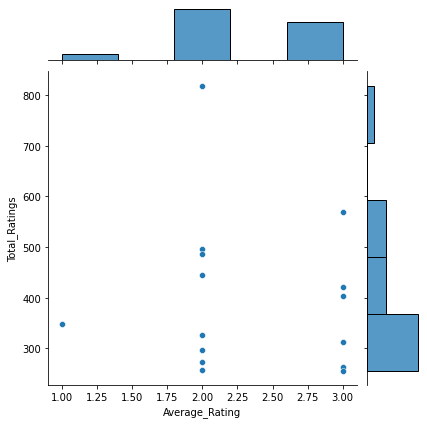

In [ ]:
# Joint Plot:
import seaborn as sns
sns.jointplot(x='Average_Rating', y='Total_Ratings', data=df22)

In [ ]:
df

,title,userID,rating,review,class
22,"ERAGON: INHERITANCE, BOOK ONE.",A3T18VLRQS59L0,1.0,one of the worst books i have ever read ever i...,Negative
25,"ERAGON: INHERITANCE, BOOK ONE.",A1PNBYBWGWWVEK,1.0,ahhh after reading the dying earth by jack van...,Negative
34,The Bear and the Dragon,A3CU0U5RY99NXJ,1.0,this book took so long to write that clancy fo...,Negative
35,The Devil Wears Prada,A2FAAYH5AVTGG0,1.0,while the most prominent character is the alwa...,Negative
53,"ERAGON: INHERITANCE, BOOK ONE.",A123DKR2C0ENHY,2.0,i bought the sample and just couldnt get into ...,Negative
...,...,...,...,...,...
62425,A confederacy of dunces,ASNWGSAJZI99V,4.0,the charector is a little too annoying and may...,Positive
62428,The Great Gatsby,A1WCJEZS66D224,5.0,this is absolutely my favorite novel of all ti...,Positive
62450,Fahrenheit 451,A1HL8QSFHAYWVI,5.0,generally my favorite bradbury illustrator is ...,Positive
62459,The Devil Wears Prada,A5UWC7ZERWGY6,5.0,my favorite quote was when andrea is talking a...,Positive


In [ ]:
df = df.drop(['class'], axis=1)

In [ ]:
df.rating = df.rating.astype(float)

In [ ]:
df.head()

,title,userID,rating,review
22,"ERAGON: INHERITANCE, BOOK ONE.",A3T18VLRQS59L0,1.0,one of the worst books i have ever read ever i...
25,"ERAGON: INHERITANCE, BOOK ONE.",A1PNBYBWGWWVEK,1.0,ahhh after reading the dying earth by jack van...
34,The Bear and the Dragon,A3CU0U5RY99NXJ,1.0,this book took so long to write that clancy fo...
35,The Devil Wears Prada,A2FAAYH5AVTGG0,1.0,while the most prominent character is the alwa...
53,"ERAGON: INHERITANCE, BOOK ONE.",A123DKR2C0ENHY,2.0,i bought the sample and just couldnt get into ...


In [ ]:
book_matrix = df.pivot_table(index='userID', columns='title', values='rating')
book_matrix.head()

title,1984,A confederacy of dunces,Dreamcatcher Movie-Tie In,Dune,"ERAGON: INHERITANCE, BOOK ONE.",Fahrenheit 451,"Julie and Julia: 365 Days, 524 Recipes, 1 Tiny Apartment Kitchen: How One Girl Risked Her Marriage, Her Job, and Her ... Living",Lord of the flies,The Bear and the Dragon,The Devil Wears Prada,The Giver,The Great Gatsby,"The Hobbitt, or there and back again; illustrated by the author.",The Notebook,"The Shelters Of Stone - The Earth's Children Series, Book 5"
userID,,,,,,,,,,,,,,,
A054179626QUH22ZAZTAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
A0844216213AV73HU4KN6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
A100JEV1I8ZHJ8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
A100NE7N89DVC0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A101DG7P9E26PW,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def getCo(bookName):
  # Collect the rate Similarities:
  book_rate = book_matrix[bookName]
  similar_to_air_book =book_matrix.corrwith(book_rate)
  return similar_to_air_book

In [ ]:
def recommend(bookName,feedBack):
  if feedBack =="Positive":
    return getCo(bookName).idxmax()
  else : 
    return getCo(bookName).idxmin()

In [ ]:
b = list(df.title)[0]
recommend(b,"Positive")

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


'Julie and Julia: 365 Days, 524 Recipes, 1 Tiny Apartment Kitchen: How One Girl Risked Her Marriage, Her Job, and Her ... Living'

In [ ]:
b = list(df.title)[0]
recommend(b,"Neutral")

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


'The Hobbitt, or there and back again; illustrated by the author.'

# Saving file to be used with endpoint

In [ ]:
df.to_csv('book.csv',index=False)


# Referances 
1. https://github.com/ashima96/Book-Recommendation-System